In [1]:
%env CUDA_VISIBLE_DEVICES=3
import sys
sys.path.append('/home/a_razumov/projects/k-space-mri')
import numpy as np
import pylab as plt
import pickle
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.datasets.acdc import ACDCSet, ACDCTransform, RandomMaskFunc
from k_space_reconstruction.datasets.fastmri import FastMRIh5Dataset, FastMRITransform, LegacyFastMRIh5Dataset
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt

import os
import sys
from k_space_reconstruction.nets.unet import Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import albumentations
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import nibabel

import torch
import torch.utils.data
import torch.nn as nn
import torchvision.transforms as transforms
import torchio

from os.path import isdir, join
from typing import Callable, Dict, List, Any

env: CUDA_VISIBLE_DEVICES=3


In [2]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)

        return mask

In [3]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(2 * nc, 4), dpi=100, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))

def ce_loss(true, logits, weights, ignore=255):
    ce_loss = torch.nn.functional.cross_entropy(
        logits.float(),
        true.long(),
        ignore_index=ignore,
        weight=weights,
    )
    return ce_loss


def dice_loss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def dice_coeff_3d_classes(true, logits, eps=1e-11):
    num_classes = logits.shape[0]
    probas = torch.nn.functional.softmax(logits, dim=0)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes): pmask[0] += probas[i] * i
    dice_ls = []
    # WT
    true_1_hot = ((true==1) | (true==2) | (true==3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==2) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    # ET
    true_1_hot = ((true==1) | (true==3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    # TC
    true_1_hot = ((true==1)).float().flatten()
    pred_1_hot = ((pmask==1)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    return dice_ls

def train_sampling_pattern(train_generator, model, n=16, verbose=True):
    w = torch.zeros(4,240).cuda().float()
    w[:,120] = 1
    w_list = []
    bbatch_size = 110
    criterion = lambda p,t : dice_loss(t.movedim(1,2).reshape(-1,1,240,240), p.movedim(1,2).reshape(-1,4,240,240))
    for count in range(n):
        w = torch.autograd.Variable(w, requires_grad=True)
        pbar = tqdm(enumerate(train_generator), total=len(train_generator), leave=False, disable=not verbose)
        for I, (mask, img, mean, std) in pbar:
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            ks = Ft(img * std + mean)
            img = (IFt(ks * w.unsqueeze(1).unsqueeze(0).unsqueeze(-1)).abs() - mean) / (std + 1e-11)
            pred = model(img)
            loss = criterion(pred, mask)
            if torch.isnan(loss):
                print('warn')
                continue
            loss.backward()
        w_grad = w.grad.cpu().detach()
        w = w.detach()
        for j in range(4):
            for i in torch.topk(w_grad[j,:], 240, largest=False).indices:
                if w[j,i] == 0: 
                    w[j,i] = 1.
                    pbar.set_description('select: %d, loss: %.6f' % (i.item(), loss.item()))
                    break
        w_list.append(w.clone())
        w = torch.autograd.Variable(w, requires_grad=True)
    return w_list

def loss_fn(p, t):
    p = p.movedim(1, 2).reshape(-1, 4, 240, 240)
    t = t.movedim(1, 2).reshape(-1, 1, 240, 240)
    return dice_loss(t, p) * .75 + ce_loss(t.squeeze(1), p, weights=None) * .25

def finetune_model_on_sampling(train_generator, model, sampling, epochs=5, return_losses=False, verbose=True):
    if not os.path.exists('brats_unet3d_checkpoints'):
        os.makedirs('brats_unet3d_checkpoints')
    losses = np.zeros(epochs)
    checkpoints = []
    criterion = lambda p,t : loss_fn(p,t)
    metric = lambda p,t : loss_fn(p,t)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
    for epoch in range(epochs):
        model = model.train()
        pbar2 = tqdm(train_generator, total=len(train_generator), disable=not verbose)
        for targets, images, means, stds in pbar2:
            images = images.cuda(); targets = targets.cuda(); means = means.cuda(); stds = stds.cuda()
            optimizer.zero_grad()
            # backpropagate
            ks = Ft(images * stds + means)
            images = (IFt(ks * sampling).abs() - means) / (stds + 1e-11)
            pred = model(images)
            loss = criterion(pred, targets)
            loss.backward()
            optimizer.step()
            losses[epoch] += loss.item() / len(train_generator)
            pbar2.set_description('[epoch %d | %d] loss: %.6f' % (epoch, epochs, loss.item()))
        model = model.train(False).eval()
        checkpoint_path = join('brats_unet3d_checkpoints', 'epoch%d.pth' % epoch)
        torch.save(model.state_dict(), checkpoint_path)
        checkpoints.append(checkpoint_path)
    del optimizer
    best_checkpoint = checkpoints[np.argmin(losses)]
    model.load_state_dict(torch.load(best_checkpoint))
    if return_losses:
        return model, losses
    else:
        return model

def test_sampling_pattern(sampling, model, val_generator):
    dice_scores = []
    with torch.no_grad():
        for mask, img, mean, std in tqdm(val_generator):
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            ks = Ft(img * std + mean)
            img = (IFt(ks * sampling).abs() - mean) / (std + 1e-11)
            pred = model(img)
            dice_scores.append(1 - dice_loss(mask, pred).item())
    return dice_scores

def test_3d_sampling_pattern(sampling, model, val_3d_dataset):
    dice_scores = []
    with torch.no_grad():
        for i in tqdm(range(len(val_3d_dataset))):
            mask, img, mean, std = val_3d_dataset[i]
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            img = (IFt(Ft(img * std + mean) * sampling).abs() - mean) / (std + 1e-11)
            if i==0: plt.imshow(img[0,90].cpu().detach()); plt.show()
            logits = model(img.cuda().float().unsqueeze(0))[0]
            dice_scores.append(np.mean(dice_coeff_3d_classes(mask, logits)))
    return dice_scores

def test_3d_on_classes_sampling_pattern(sampling, model, val_3d_dataset):
    dice_scores = []
    with torch.no_grad():
        for i in tqdm(range(len(val_3d_dataset))):
            mask, img, mean, std = val_3d_dataset[i]
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            img = (IFt(Ft(img * std + mean) * sampling).abs() - mean) / (std + 1e-11)
            if i==0: plt.imshow(img[0,90].cpu().detach()); plt.show()
            logits = model(img.cuda().float().unsqueeze(0))[0]
            dice_scores.append(dice_coeff_3d_classes(mask, logits))
    return dice_scores


class BraTS3dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug=None, indexes=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug = aug
        if indexes is not None:
            self.indexes = [str(i) for i in indexes]
        else:
            self.indexes = [k for k in self.hf.keys()]

    def __len__(self) -> int:
        return len(self.indexes)
    
    def __getitem__(self, item: int):
        key = self.indexes[item]
        img = self.hf[key][:-1,:,:,:]
        mask = self.hf[key][-1:,:,:,:]
        mask[mask==4] = 3
        if self.aug:
            aug = self.aug(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask).long()
        img = img.movedim(3,1)
        mask = mask.movedim(3,1)
        mean = img.mean(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        std = img.std(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        img = (img - mean) / (std + 1e-11)
        return mask, img, mean, std

In [4]:
def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

In [5]:
np.random.seed(42)
torch.manual_seed(42)

CKPT_PATH = 'unet3d-brats.pt'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = UNet3d(in_channels=4, n_classes=4, n_channels=24).to(device).train(False).eval()
model.load_state_dict(torch.load(CKPT_PATH))
    
train_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5')
val_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/val.h5')

In [6]:
len(train_3d_dataset), len(val_3d_dataset)

(258, 111)

# 5-fold finetune

In [ ]:
import contextlib
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()

model_zm = UNet3d(in_channels=4, n_classes=4, n_channels=24).to(device).train(False).eval()
model_zm.load_state_dict(torch.load(CKPT_PATH))
model_igs = UNet3d(in_channels=4, n_classes=4, n_channels=24).to(device).train(False).eval()
model_igs.load_state_dict(torch.load(CKPT_PATH))
model_fastmri = UNet3d(in_channels=4, n_classes=4, n_channels=24).to(device).train(False).eval()
model_fastmri.load_state_dict(torch.load(CKPT_PATH))

dice_fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(tqdm(KFold(shuffle=False).split(range(len(train_3d_dataset))))):
    # reset model states
    model_igs.load_state_dict(torch.load(CKPT_PATH))
    model_zm.load_state_dict(torch.load(CKPT_PATH))
    model_fastmri.load_state_dict(torch.load(CKPT_PATH))
    # set train val split
    td = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', indexes=train_id)
    vd = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', indexes=val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=1, shuffle=True)
    tgt = torch.utils.data.DataLoader(td, batch_size=2, shuffle=True, num_workers=2)
    # center
    model_zm = finetune_model_on_sampling(tgt, model_zm, zm, verbose=False)
    # fastmri
    model_fastmri = finetune_model_on_sampling(tgt, model_fastmri, fastmri_mask_x16, verbose=False)
    # ours
    w = train_sampling_pattern(tg, model, n=15, verbose=False)[14]
    model_igs = finetune_model_on_sampling(tgt, model_igs, w.unsqueeze(2).unsqueeze(1), verbose=False)
    dice_fold_scores[i] = dict(
        ours=test_3d_sampling_pattern(w.unsqueeze(2).unsqueeze(1), model_igs, vd),
        fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model_fastmri, vd), 
        center=test_3d_sampling_pattern(zm, model_zm, vd),
    )
fold_scores = [vd for vd in dice_fold_scores.values()]
with open('unet_finetune_fold_scores.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

In [8]:
with open('unet_finetune_fold_scores.pkl', 'rb') as f: fold_scores = pickle.load(f)

In [9]:
import scipy

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-0.3961885897215179, pvalue=0.7121912043279433)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.642199,0.652259,0.664056
std,0.024461,0.040757,0.027096
min,0.608031,0.585930,0.636457
25%,0.626091,0.642020,0.638810
50%,0.650970,0.669146,0.663757
75%,0.659209,0.676015,0.682706
max,0.666696,0.688184,0.698550


# Training on full train

In [ ]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()

model_zm = UNet3d(in_channels=4, n_classes=4, n_channels=24).to(device).train(False).eval()
model_zm.load_state_dict(torch.load(CKPT_PATH))
model_igs = UNet3d(in_channels=4, n_classes=4, n_channels=24).to(device).train(False).eval()
model_igs.load_state_dict(torch.load(CKPT_PATH))
model_fastmri = UNet3d(in_channels=4, n_classes=4, n_channels=24).to(device).train(False).eval()
model_fastmri.load_state_dict(torch.load(CKPT_PATH))

tg = torch.utils.data.DataLoader(train_3d_dataset, batch_size=1)
tgt = torch.utils.data.DataLoader(train_3d_dataset, batch_size=2, shuffle=True, num_workers=2)

w = train_sampling_pattern(tg, model_igs, n=15)[14]
model_igs, losses_igs = finetune_model_on_sampling(tgt, model_igs, w.unsqueeze(2).unsqueeze(1), return_losses=True)
model_zm, losses_zm = finetune_model_on_sampling(tgt, model_zm, zm, return_losses=True)
model_fastmri, losses_fastmri = finetune_model_on_sampling(tgt, model_fastmri, fastmri_mask_x16, return_losses=True)

In [8]:
torch.save(w, 'sampling_igs_finetune.pt')
torch.save(model_fastmri.state_dict(), 'model_fastmri.pt')
torch.save(model_zm.state_dict(), 'model_zm.pt')
torch.save(model_igs.state_dict(), 'model_igs.pt')

# Eval on full val

In [7]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()
w = torch.load('sampling_igs_finetune.pt')

model = UNet3d(in_channels=4, n_classes=4, n_channels=24).to(device).train(False).eval()
model.load_state_dict(torch.load(CKPT_PATH))
model_zm = UNet3d(in_channels=4, n_classes=4, n_channels=24).to(device).train(False).eval()
model_zm.load_state_dict(torch.load('model_zm.pt'))
model_igs = UNet3d(in_channels=4, n_classes=4, n_channels=24).to(device).train(False).eval()
model_igs.load_state_dict(torch.load('model_igs.pt'))
model_fastmri = UNet3d(in_channels=4, n_classes=4, n_channels=24).to(device).train(False).eval()
model_fastmri.load_state_dict(torch.load('model_fastmri.pt'))

<All keys matched successfully>

In [8]:
fastmri_mask_x16.sum(), zm.sum(), w[0].sum()

(tensor(16., device='cuda:0'),
 tensor(16., device='cuda:0'),
 tensor(16., device='cuda:0'))

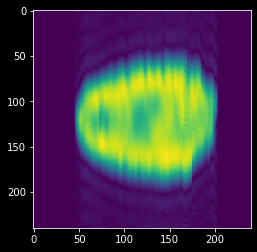

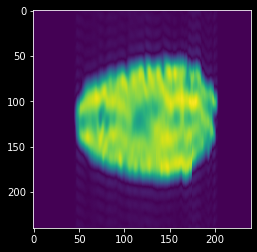

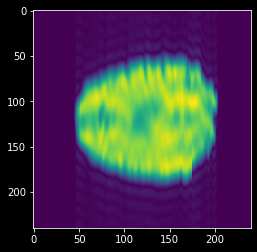

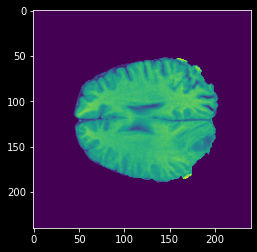

In [13]:
dice_fold_scores = dict(
    fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model_fastmri, val_3d_dataset), 
    center=test_3d_sampling_pattern(zm, model_zm, val_3d_dataset),
    ours=test_3d_sampling_pattern(w.unsqueeze(2).unsqueeze(1), model_igs, val_3d_dataset),
    full=test_3d_sampling_pattern(fm, model, val_3d_dataset),
)

In [14]:
pd.DataFrame.from_dict(dice_fold_scores).describe()

,fastmri,center,ours,full
count,111.000000,111.000000,111.000000,111.000000
mean,0.601383,0.583833,0.655354,0.767875
std,0.203984,0.240024,0.194395,0.171178
min,0.005259,0.000000,0.000000,0.276735
25%,0.507610,0.435981,0.572773,0.657315
50%,0.656780,0.670593,0.714823,0.829767
75%,0.762699,0.777552,0.794271,0.904393
max,0.868436,0.875991,0.886454,0.963060


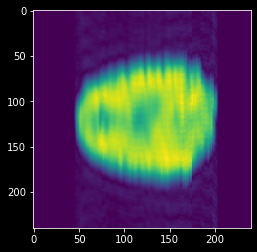

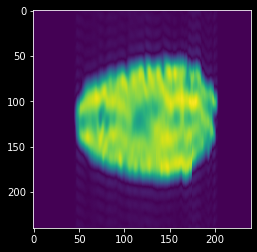

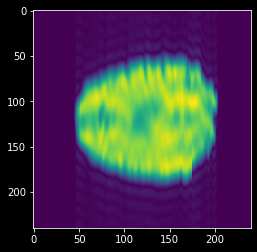

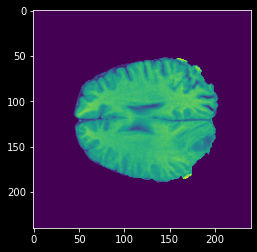

In [9]:
dice_class_scores = dict(
    fastmri=test_3d_on_classes_sampling_pattern(fastmri_mask_x16, model_fastmri, val_3d_dataset), 
    center=test_3d_on_classes_sampling_pattern(zm, model_zm, val_3d_dataset),
    ours=test_3d_on_classes_sampling_pattern(w.unsqueeze(2).unsqueeze(1), model_igs, val_3d_dataset),
    full=test_3d_on_classes_sampling_pattern(fm, model, val_3d_dataset),
)

In [10]:
class_map = {0: 'WT', 1: 'ET', 2: 'TC'}
for name in dice_class_scores.keys():
    arr = np.array(dice_class_scores[name]).T
    print('##############', name, '##############')
    print(pd.DataFrame.from_dict({class_map[i]:arr[i] for i in range(arr.shape[0])}).describe())

############## fastmri ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.739202    0.650229    0.448412
std      0.165357    0.254307    0.261365
min      0.019746    0.000000    0.000000
25%      0.689498    0.561305    0.219743
50%      0.803814    0.753798    0.492245
75%      0.848855    0.833803    0.671458
max      0.915503    0.920412    0.880062
############## center ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.739068    0.622787    0.389643
std      0.201847    0.304723    0.302948
min      0.000000    0.000000    0.000000
25%      0.722522    0.430677    0.053135
50%      0.812829    0.766679    0.400181
75%      0.862772    0.855595    0.688865
max      0.932139    0.922010    0.867449
############## ours ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.786780    0.698200    0.481084
std     